<a href="https://colab.research.google.com/github/fagan-id/Prediksi-Respons-Pelanggan-terhadap-Strategi-Pemasaran-Menggunakan-Algoritma-Random-Forest/blob/main/Kelompok_8_Kecerdasan_Artificial_Prediksi_Respons_Pelanggan_terhadap_Strategi_Pemasaran_Menggunakan_Algoritma_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. EDA (Exploratory Data Analysis)**

Instalasi Library

In [2]:
!pip install imbalanced-learn scikit-plot==0.3.7 kaggle -q

Import Library

In [3]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pickle

Akses Dataset dari Kaggle

In [4]:
# Upload kaggle.json
from google.colab import files
files.upload()

# Setup Kaggle API
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d imakash3011/customer-personality-analysis
!unzip customer-personality-analysis.zip

# Load data
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Data shape:", data.shape)
data.head()

Saving marketing_campaign.csv to marketing_campaign.csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open customer-personality-analysis.zip, customer-personality-analysis.zip.zip

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Menampilkan tipe data, missing values, dan jumlah entri per kolom.

In [5]:
# Cek info awal (EDA)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Menunjukkan statistik ringkasan seperti mean, std, min, max. Penting untuk mengenali anomali atau outlier.

In [6]:
print(data.describe())

                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000     0.000000  

Visualisasi ketimpangan kelas (imbalanced data). Ini alasan utama kami pakai SMOTE.

In [7]:
print(data['Response'].value_counts())

Response
0    1906
1     334
Name: count, dtype: int64


memeriksa jumlah missing values.

In [8]:
print(data.isnull().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


dimensi dataset.

In [9]:
print(data.shape)

(2240, 29)


**2. Data Preprocessing** (Data Cleaning, Feature Engineering, Handle Class Imbalance)

Data Cleaning

In [10]:
# Handle missing values
data['Income'] = data['Income'].fillna(data['Income'].median())

# Print columns to check their names
print("Columns before dropping:", data.columns.tolist())

# Drop kolom tidak perlu
# Add errors='ignore' to prevent the error if columns are already gone
data = data.drop(columns=['Z_CostContact', 'Z_Revenue', 'ID'], errors='ignore')

# Cek hasil
print("Missing values setelah cleaning:\n", data.isnull().sum())
print("Columns after dropping:", data.columns.tolist()) # Check columns after dropping

Columns before dropping: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
Missing values setelah cleaning:
 Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3     

Feature Engineering

In [11]:
# Membuat fitur baru
data['Age'] = 2023 - data['Year_Birth']

# Mengonversi 'Dt_Customer' ke tipe datetime, menangani kesalahan dengan coercing ke NaT
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], errors='coerce')
data['Dt_Customer'] = data['Dt_Customer'].fillna(data['Dt_Customer'].mode().iloc[0])
# Ekstrak tahun dari kolom datetime dan hitung durasi pelanggan.
# Tangani nilai NaT yang mungkin muncul setelah konversi.
data['Customer_Duration'] = 2023 - data['Dt_Customer'].dt.year

# Ganti nilai NaN yang mungkin muncul dari NaT setelah perhitungan durasi (jika perlu)
# Calculate the median *before* filling NaNs to avoid including NaNs in the median calculation
median_customer_duration = data['Customer_Duration'].median()
data['Customer_Duration'] = data['Customer_Duration'].fillna(median_customer_duration)

data['Total_Spending'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
data['Total_Accepted_Campaigns'] = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# Target variable
data['Response'] = data['Response'].apply(lambda x: 1 if x == 1 else 0)

# Memilih fitur akhir
features = ['Income', 'Recency', 'Age', 'Customer_Duration', 'Total_Spending',
            'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
            'NumWebVisitsMonth', 'Total_Accepted_Campaigns', 'Kidhome', 'Teenhome']
target = 'Response'

X = data[features]
y = data[target]

In [12]:
print(data.isnull().sum())

Year_Birth                  0
Education                   0
Marital_Status              0
Income                      0
Kidhome                     0
Teenhome                    0
Dt_Customer                 0
Recency                     0
MntWines                    0
MntFruits                   0
MntMeatProducts             0
MntFishProducts             0
MntSweetProducts            0
MntGoldProds                0
NumDealsPurchases           0
NumWebPurchases             0
NumCatalogPurchases         0
NumStorePurchases           0
NumWebVisitsMonth           0
AcceptedCmp3                0
AcceptedCmp4                0
AcceptedCmp5                0
AcceptedCmp1                0
AcceptedCmp2                0
Complain                    0
Response                    0
Age                         0
Customer_Duration           0
Total_Spending              0
Total_Accepted_Campaigns    0
dtype: int64


Handle Class Imbalance

In [34]:
# Cek jumlah kelas sebelum SMOTE
print("Sebelum SMOTE:", y.value_counts())

# 1. Split data train-test dulu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Jumlah kelas di training sebelum SMOTE:", y_train.value_counts())
print("Jumlah kelas di testing:", y_test.value_counts())

# 2. Terapkan SMOTE untuk balancing kelas
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 3. Cek jumlah kelas setelah SMOTE
print("Jumlah kelas di training setelah SMOTE:", pd.Series(y_train_res).value_counts())


Sebelum SMOTE: Response
0    1906
1     334
Name: count, dtype: int64
Jumlah kelas di training sebelum SMOTE: Response
0    1329
1     239
Name: count, dtype: int64
Jumlah kelas di testing: Response
0    577
1     95
Name: count, dtype: int64
Jumlah kelas di training setelah SMOTE: Response
0    1329
1    1329
Name: count, dtype: int64


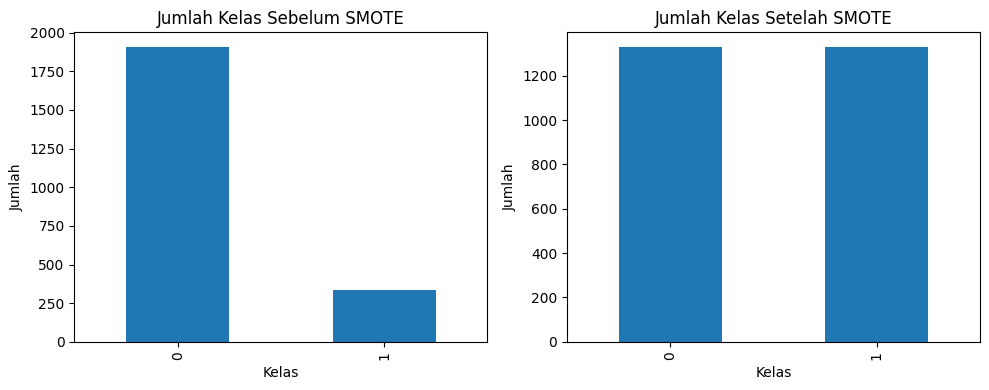

In [35]:
plt.figure(figsize=(10,4))

# Visualisasi sebelum SMOTE
plt.subplot(1,2,1)
y.value_counts().plot(kind='bar')
plt.title('Jumlah Kelas Sebelum SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')

# Visualisasi setelah SMOTE
plt.subplot(1,2,2)
pd.Series(y_train_res).value_counts().plot(kind='bar')
plt.title('Jumlah Kelas Setelah SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()


In [37]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

**4. Model Training**

In [40]:
# Training Random Forest dengan GridSearch
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train_res)

# Model terbaik
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


**5. Evaluasi Model**

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       581
           1       0.87      0.93      0.89       563

    accuracy                           0.89      1144
   macro avg       0.89      0.89      0.89      1144
weighted avg       0.89      0.89      0.89      1144



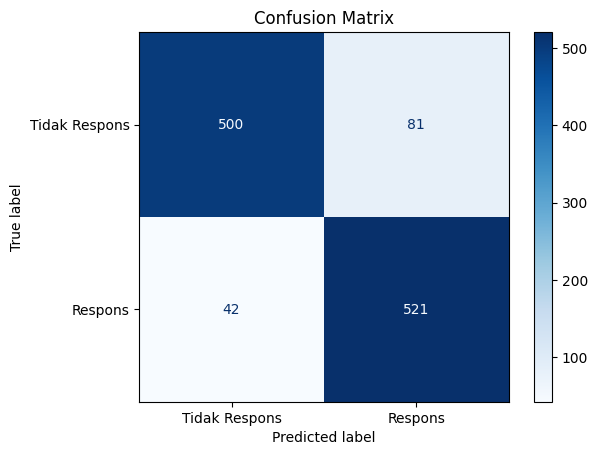

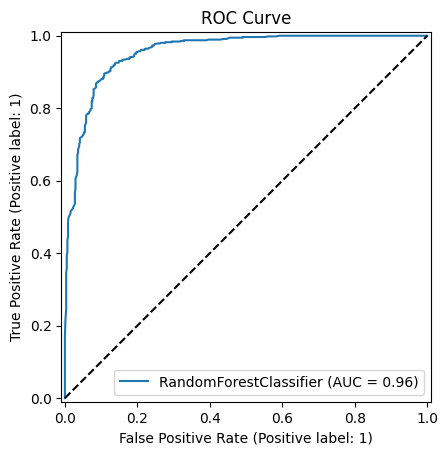

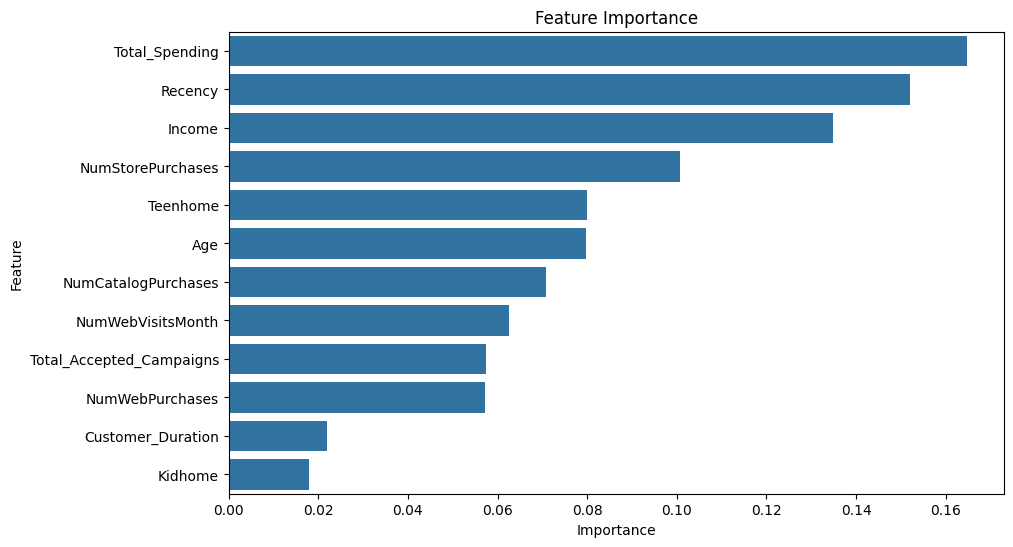

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Generate predictions on the test set
y_pred = best_rf.predict(X_test_scaled)

# 1. Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# 2. Confusion Matrix (versi sklearn)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                      cmap='Blues',
                                      display_labels=['Tidak Respons', 'Respons'])
plt.title('Confusion Matrix')
plt.show()

# 3. ROC Curve (versi sklearn)
RocCurveDisplay.from_estimator(best_rf, X_test_scaled, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')  # Garis acak
plt.show()

# 4. Feature Importance
feature_imp = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_rf, X_res, y_res, cv=5, scoring='roc_auc')
print("CV ROC AUC:", cv_scores.mean())

CV ROC AUC: 0.9677111667777728


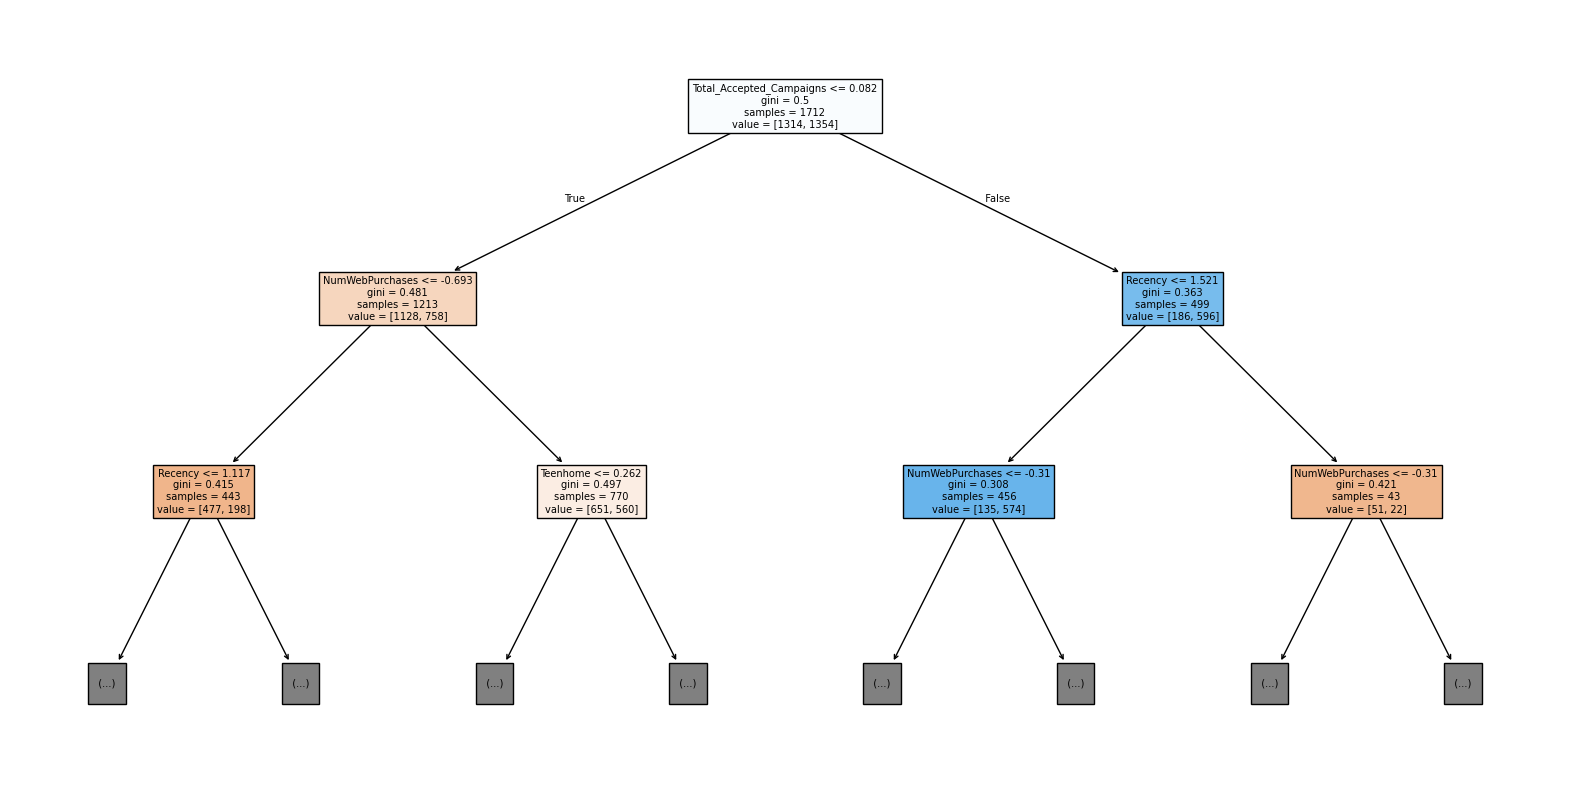

In [ ]:
# 1. OOB Score (khusus Random Forest)
if hasattr(best_rf, 'oob_score_'):
    print("OOB Score:", best_rf.oob_score_)  # Hanya ada jika oob=True saat training

# 2. Visualisasi Decision Tree (contoh 1 tree)
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(best_rf.estimators_[0], feature_names=features, filled=True, max_depth=2)
plt.show()

In [ ]:
print("Insight: Pelanggan dengan Income tinggi memiliki",
      round(feature_imp.loc[feature_imp['Feature']=='Income', 'Importance'].values[0]*100, 2),
      "% pengaruh terhadap respons kampanye")

Insight: Pelanggan dengan Income tinggi memiliki 13.49 % pengaruh terhadap respons kampanye
